/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


(402, 7)
   USE     RS        RS_ALT           GEN     SHAPE_LENG    SHAPE_AREA  \
0    4  01001  010010000000     Flensburg   32467.034276  5.324899e+07   
1    4  01002  010020000000          Kiel   73027.302434  1.218654e+08   
2    4  01003  010030000000        Lübeck  104861.094220  2.211386e+08   
3    4  01004  010040000000    Neumünster   39858.818376  8.092363e+07   
4    4  01051  010510000000  Dithmarschen  202206.675707  1.450311e+09   

                                            geometry  
0  POLYGON ((9.48982 54.82296, 9.50467 54.81004, ...  
1  POLYGON ((10.19057 54.38909, 10.18370 54.38910...  
2  POLYGON ((10.89297 53.95695, 10.90337 53.95705...  
3  POLYGON ((10.03454 54.12915, 10.02277 54.10938...  
4  MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3...  


<AxesSubplot:>

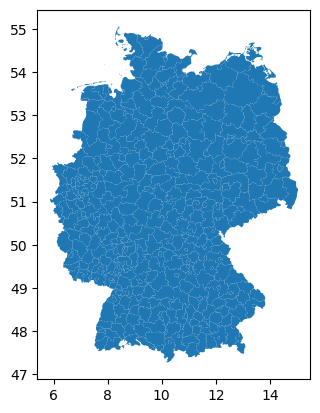

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
import geopandas as gpd
import collections
from PythonFiles.model import model,preprocessing
from PythonFiles.Configuration import Configuration
config = Configuration()
df = gpd.read_file('vg2500_krs.shp')
df = df.set_geometry('geometry')

print(df.shape)
print(df.head())  
df.plot()

## Match the names in Influenza.csv to the names in the Shapefile

In [3]:
influenza_df = pd.read_csv("Influenza.csv", sep=',')
locations = influenza_df.location.unique()

In [4]:
names = list(df.GEN.unique())
renaming_dict = dict()
# Iterate over the names defined by the Shapefile
for name in names:
    renaming_dict[name] = []
    # then iterate over the locations names defined by the influenza.csv file
    for location in locations:
        # filter out the names, where the Shapefile-Name String is part of the Influenza-File-Name String, and save them to the dict
        if name in location:
            renaming_dict[name].append(location) 
    if name in config.specific_matches.keys():
        renaming_dict[name] = config.specific_matches[name]
print(renaming_dict)
            
# Some specific matches have to be defined within a config dictionary [specific_matches]
#for key in config.specific_matches.keys():
 #   if key in list(renaming_dict.keys()):
  #      renaming_dict[key] = config.specific_matches[key]

        

not_matching_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if ((len(v)==0) | (len(v)>1))}

correctly_matched_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if len(v) == 1}

#remaining_loc = [location for location in locations if location not in [location[0] for location in correctly_matched_dict.values()]]
not_renamed_shapefile_locations = []

# iterate over not correctly matched locations
for name in not_matching_dict.keys():
    unmatched_df = df[df.GEN == name].copy()
    # locations with double region "lK" and "SK" are correctly selected by their shape length
    if len(unmatched_df) > 1:
        unmatched_df.loc[unmatched_df['SHAPE_LENG'] == min(unmatched_df['SHAPE_LENG']),"location"] = f"SK {name}"
        unmatched_df.loc[unmatched_df['SHAPE_LENG'] == max(unmatched_df['SHAPE_LENG']),"location"] = f"LK {name}"
    # the remaining uncorrectly matched locations are given the Shapefile name for the location column
    if len(unmatched_df) == 1:
        unmatched_df.loc[:,"location"] = f"{name}"
        not_renamed_shapefile_locations.append(name)
    # then the location column is inherited by the original df
    df.loc[df.GEN == name,'location'] = unmatched_df['location']

# then iterate over the correctly specified locations --> maybe one for loop and decide with if -> correctly matched or not 
for name in list(correctly_matched_dict.keys()):
    df.loc[df['GEN'] == name,"location"] = correctly_matched_dict[name][0]
    
if df['location'].isna().any() == True:
    print("THE DF contains nan locations.")

{'Flensburg': ['SK Flensburg'], 'Kiel': ['SK Kiel'], 'Lübeck': ['SK Lübeck'], 'Neumünster': ['SK Neumünster'], 'Dithmarschen': ['LK Dithmarschen'], 'Herzogtum Lauenburg': ['LK Herzogtum Lauenburg'], 'Nordfriesland': ['LK Nordfriesland'], 'Ostholstein': ['LK Ostholstein'], 'Plön': ['LK Plön'], 'Rendsburg-Eckernförde': ['LK Rendsburg-Eckernförde'], 'Schleswig-Flensburg': ['LK Schleswig-Flensburg'], 'Segeberg': ['LK Segeberg'], 'Steinburg': ['LK Steinburg'], 'Stormarn': ['LK Stormarn'], 'Hamburg': ['SK Hamburg'], 'Braunschweig': ['SK Braunschweig'], 'Salzgitter': ['SK Salzgitter'], 'Wolfsburg': ['SK Wolfsburg'], 'Gifhorn': ['LK Gifhorn'], 'Göttingen': ['LK Göttingen'], 'Goslar': ['LK Goslar'], 'Helmstedt': ['LK Helmstedt'], 'Northeim': ['LK Northeim'], 'Osterode am Harz': [], 'Peine': ['LK Peine'], 'Wolfenbüttel': ['LK Wolfenbüttel'], 'Region Hannover': ['Region Hannover'], 'Diepholz': ['LK Diepholz'], 'Hameln-Pyrmont': ['LK Hameln-Pyrmont'], 'Hildesheim': ['LK Hildesheim'], 'Holzminden':

### Discrepancies between the Shapefile and the Influenza.csv

In [5]:
not_implemented_influenza_locations = [location for location in influenza_df.location.unique() if location not in df.location.unique()]    
print("The following influenza locations aren't implemented yet, as they found not match within the shapefile locations:\n")
print(not_implemented_influenza_locations, "\n")
print("The following Shapefile locations remained unchanged, as they found no match within the influenza locations:\n")
print(not_renamed_shapefile_locations)

The following influenza locations aren't implemented yet, as they found not match within the shapefile locations:

['SK Berlin Charlottenburg-Wilmersdorf', 'SK Berlin Friedrichshain-Kreuzberg', 'SK Berlin Lichtenberg', 'SK Berlin Marzahn-Hellersdorf', 'SK Berlin Mitte', 'SK Berlin Neukölln', 'SK Berlin Pankow', 'SK Berlin Reinickendorf', 'SK Berlin Spandau', 'SK Berlin Steglitz-Zehlendorf', 'SK Berlin Tempelhof-Schöneberg', 'SK Berlin Treptow-Köpenick'] 

The following Shapefile locations remained unchanged, as they found no match within the influenza locations:

['Osterode am Harz', 'Berlin', 'Eisenach']


In [5]:
#print(list(df[df.GEN.isin(["Berlin",""])].my_neighbors))
#df[df.GEN.isin(["Berlin",'Potsdam', 'Barnim', 'Dahme-Spreewald', 'Havelland', 'Märkisch-Oderland', 'Oberhavel', 'Oder-Spree', 'Potsdam-Mittelmark', 'Teltow-Fläming'])].plot()

In [6]:
matrix_df = pd.DataFrame(columns=config.berlin_neighbors.keys(), index=config.berlin_neighbors.keys())
for key in config.berlin_neighbors.keys():
    neighbors = config.berlin_neighbors[key]
    if len(neighbors)>0:
        for neighbor in neighbors:
            matrix_df.loc[key, neighbor] = 1
            matrix_df.loc[neighbor, key] = 1
            matrix_df.loc[key, key] = 0
    else:
        print(key)
matrix_df = matrix_df.fillna(0)
#print(matrix_df)
#print(matrix_df.isna().sum())
#print(len(df.location.unique()))
display(matrix_df)

,SK Berlin Charlottenburg-Wilmersdorf,SK Berlin Friedrichshain-Kreuzberg,SK Berlin Lichtenberg,SK Berlin Marzahn-Hellersdorf,SK Berlin Mitte,SK Berlin Neukölln,SK Berlin Pankow,SK Berlin Reinickendorf,SK Berlin Spandau,SK Berlin Steglitz-Zehlendorf,...,SK Berlin Treptow-Köpenick,LK Barnim,LK Märkisch-Oderland,LK Dahme-Spreewald,LK Oberhavel,LK Havelland,SK Potsdam,LK Potsdam-Mittelmark,LK Teltow-Fläming,LK Oder-Spree
SK Berlin Charlottenburg-Wilmersdorf,0,0,0,0,1,0,0,1,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Friedrichshain-Kreuzberg,0,0,1,0,1,1,1,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Lichtenberg,0,1,0,1,0,0,1,0,0,0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Marzahn-Hellersdorf,0,0,1,0,0,0,0,0,0,0,...,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Mitte,1,1,0,0,0,0,1,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Neukölln,0,1,0,0,0,0,0,0,0,0,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Pankow,0,1,1,0,1,0,0,1,0,0,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Reinickendorf,1,0,0,0,1,0,1,0,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
SK Berlin Spandau,1,0,0,0,0,0,0,1,0,1,...,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
SK Berlin Steglitz-Zehlendorf,1,0,0,0,0,0,0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [18]:
brandenburg = [loc for location in ["Barnim", "Märkisch-Oderland", "Dahme-Spreewald", "Oberhavel", "Havelland", "Potsdam", "Teltow", "Oder-Spree"] 
               for loc in df.location.unique() 
               if location in loc]
print(brandenburg)
print(df[df.location.isin(brandenburg)])

['LK Barnim', 'LK Märkisch-Oderland', 'LK Dahme-Spreewald', 'LK Oberhavel', 'LK Havelland', 'SK Potsdam', 'LK Potsdam-Mittelmark', 'LK Teltow-Fläming', 'LK Oder-Spree']
     USE     RS        RS_ALT                 GEN     SHAPE_LENG  \
329    4  12054  120540000000             Potsdam   77639.662610   
330    4  12060  120600000000              Barnim  252284.551606   
331    4  12061  120610000000     Dahme-Spreewald  355633.541521   
333    4  12063  120630000000           Havelland  269337.702871   
334    4  12064  120640000000   Märkisch-Oderland  267987.824263   
335    4  12065  120650000000           Oberhavel  260269.943954   
337    4  12067  120670000000          Oder-Spree  291889.515373   
339    4  12069  120690000000  Potsdam-Mittelmark  372187.532160   
342    4  12072  120720000000      Teltow-Fläming  268782.123680   

       SHAPE_AREA                                           geometry  \
329  1.910131e+08  POLYGON ((13.15524 52.50122, 13.12632 52.48011...   
330  1

## Determine the neighbors and the resulting adjacent matrix based on the Shapefile

In [10]:
for index, row in df.iterrows():  
    neighbors = list(df[(df.geometry.touches(row['geometry'])) | (df.geometry.overlaps(row['geometry']))].location) 
    if type(neighbors) != list():
        neighbors = list(neighbors)
    if row.location in neighbors:   
        neighbors = neighbors.remove(row.location)
    if neighbors is not None:
        df.at[index, "my_neighbors"] = neighbors#", ".join(neighbors)
    #else: 
     #   print(f"NONE für {row.location}")
#print(neighbors)

df['my_neighbors'] = df['my_neighbors'].fillna("nan")
#df.loc[df.my_neighbors == "nan",'my_neighbors'] = ['nan']
print(list(df.my_neighbors))

[['LK Schleswig-Flensburg'], ['LK Plön', 'LK Rendsburg-Eckernförde'], ['LK Herzogtum Lauenburg', 'LK Ostholstein', 'LK Stormarn', 'LK Nordwestmecklenburg'], ['LK Plön', 'LK Rendsburg-Eckernförde', 'LK Segeberg'], ['LK Nordfriesland', 'LK Rendsburg-Eckernförde', 'LK Schleswig-Flensburg', 'LK Steinburg', 'LK Stade'], ['SK Lübeck', 'LK Stormarn', 'SK Hamburg', 'LK Harburg', 'LK Lüneburg', 'LK Ludwigslust-Parchim', 'LK Nordwestmecklenburg'], ['LK Dithmarschen', 'LK Schleswig-Flensburg'], ['SK Lübeck', 'LK Plön', 'LK Segeberg', 'LK Stormarn'], ['SK Kiel', 'SK Neumünster', 'LK Ostholstein', 'LK Rendsburg-Eckernförde', 'LK Segeberg'], ['SK Kiel', 'SK Neumünster', 'LK Dithmarschen', 'LK Plön', 'LK Schleswig-Flensburg', 'LK Segeberg', 'LK Steinburg'], ['SK Flensburg', 'LK Dithmarschen', 'LK Nordfriesland', 'LK Rendsburg-Eckernförde'], ['SK Neumünster', 'LK Ostholstein', 'LK Plön', 'LK Rendsburg-Eckernförde', 'LK Steinburg', 'LK Stormarn', 'SK Hamburg', 'LK Pinneberg'], ['LK Dithmarschen', 'LK R

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument

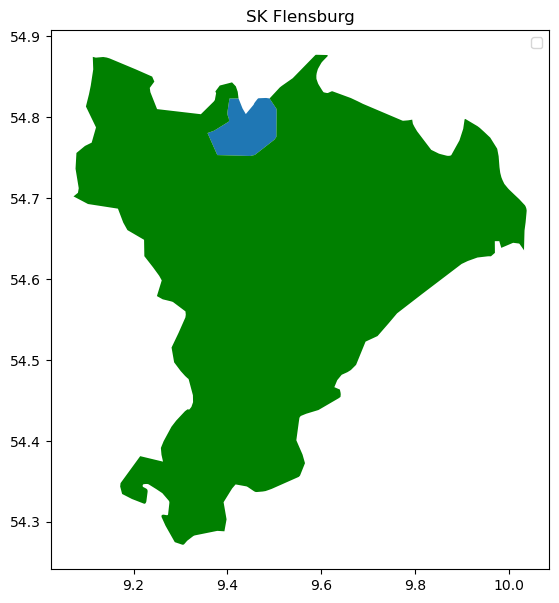

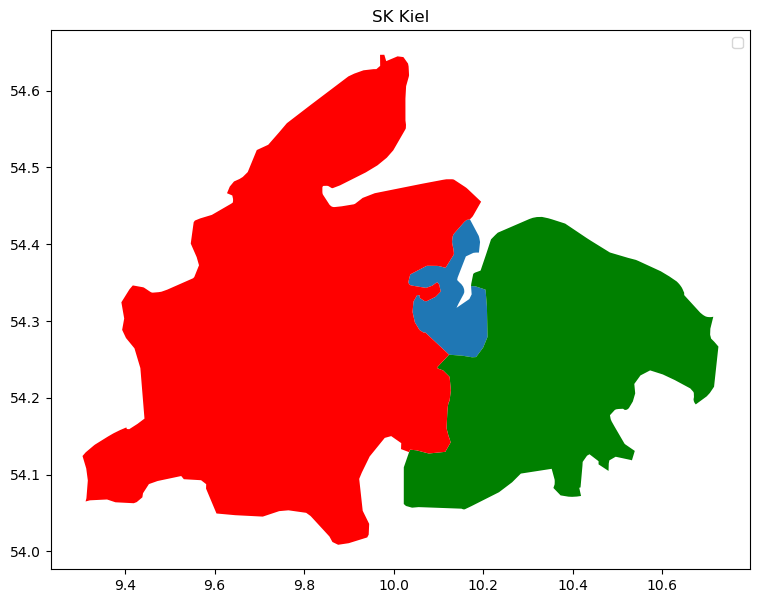

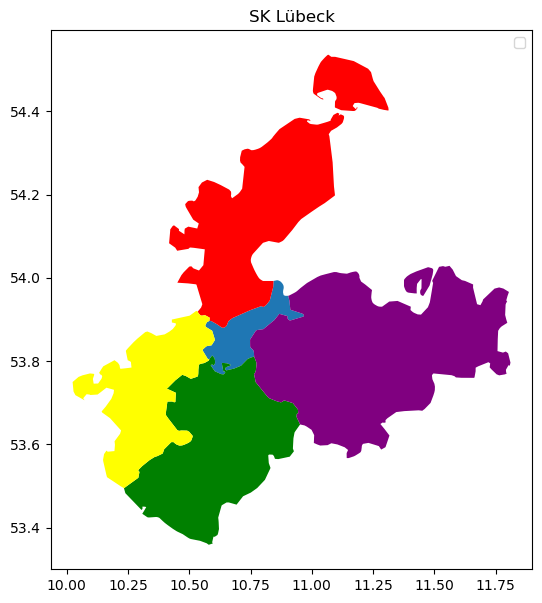

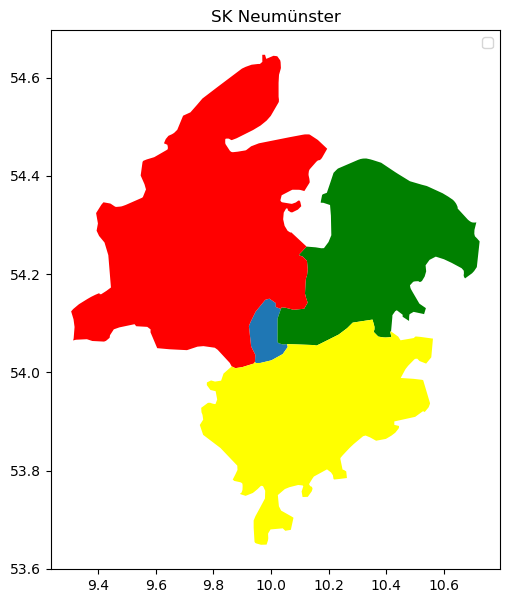

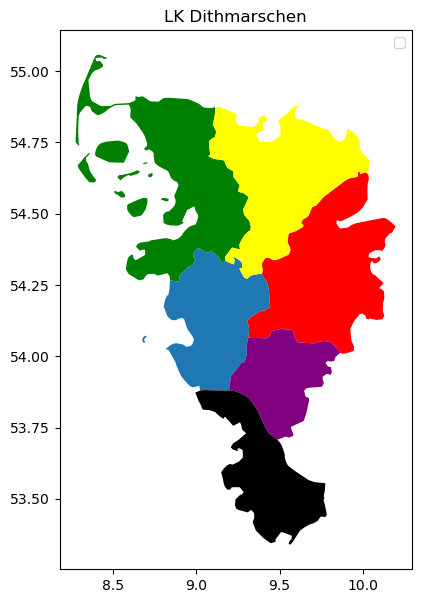

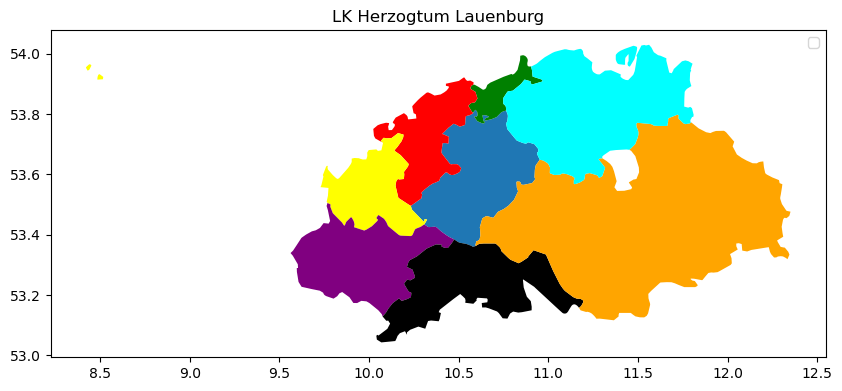

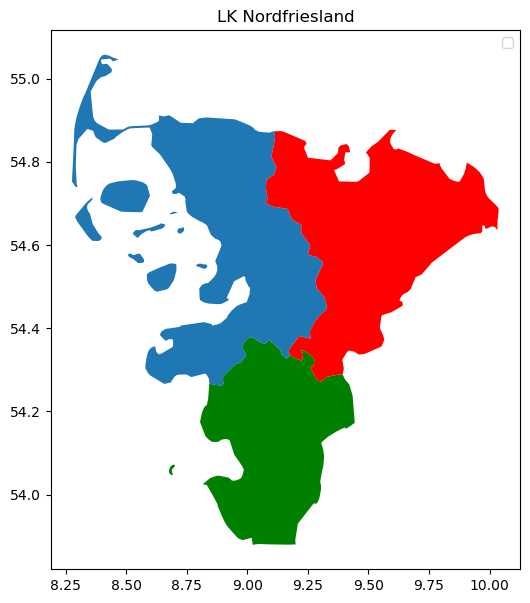

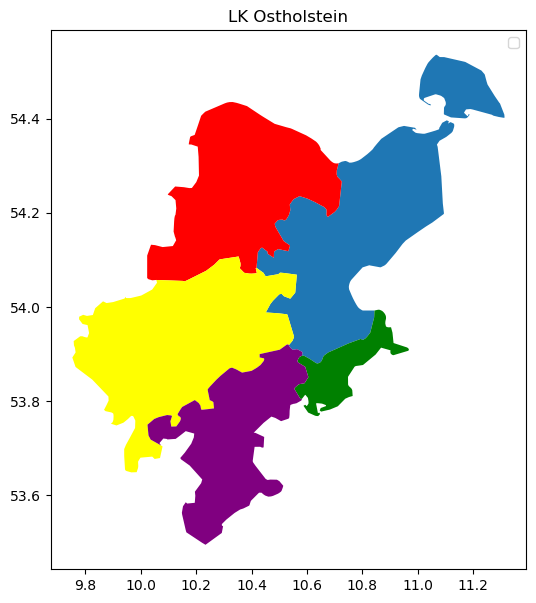

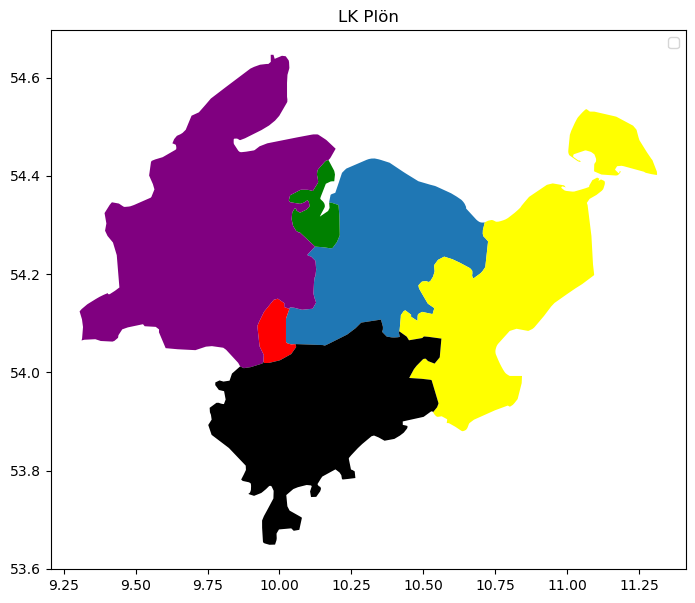

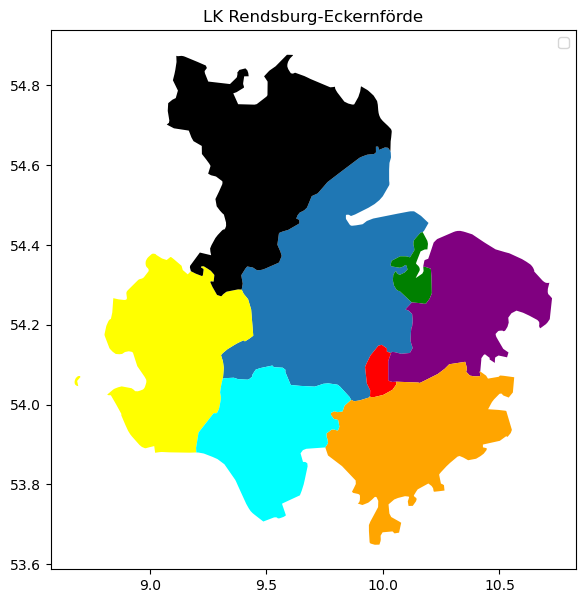

In [14]:
colors = ["green", "red", "yellow" , "purple", "black", "orange", "cyan", "magenta", "grey"]*2
for location in df.location.unique()[:10]:
    location_df = df.loc[df.location == location].copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    location_df.plot(ax=ax)
    plt.title(f"{location}")
    neighbors = list(location_df["my_neighbors"])
    if len(neighbors) >0:
        for neighbor in neighbors:
            neighbor_df = df.loc[df.location.isin(list(neighbor))].copy()
            neighbor_df.plot(neighbor_df, ax=ax, color=colors, legend=True)
    plt.legend()
plt.show()

In [30]:
matrix_df = pd.DataFrame(columns=influenza_df.location.unique(), index=influenza_df.location.unique())
for location1 in influenza_df.location.unique():
    if location1 in config.berlin_neighbors.keys():
        neighbors = config.berlin_neighbors[location1]
    else:
        location_df = df.loc[df.location == location1].copy()
        neighbors = list(location_df["my_neighbors"])[0]
        if len(neighbors)<=0:
            print(f"{location1} doesn't have any neighbors...")
    for neighbor in neighbors:
        if neighbor not in not_renamed_shapefile_locations:
            matrix_df.loc[location1, neighbor] = 1
            matrix_df.loc[neighbor, location1] = 1
            matrix_df.loc[location1, location1] = 0
matrix_df = matrix_df.fillna(0)
print(matrix_df)
print(matrix_df.isna().sum())
print(len(influenza_df.location.unique()))
#print(matrix_df.loc[matrix_df["SK Berlin Spandau"]==1,'SK Berlin Spandau'])

                       LK Alb-Donau-Kreis  LK Altenkirchen  LK Alzey-Worms  \
LK Alb-Donau-Kreis                      0                0               0   
LK Altenkirchen                         0                0               0   
LK Alzey-Worms                          0                0               0   
LK Amberg-Sulzbach                      0                0               0   
LK Ansbach                              0                0               0   
...                                   ...              ...             ...   
SK Schwerin                             0                0               0   
SK Wolfsburg                            0                0               0   
LK Ostprignitz-Ruppin                   0                0               0   
SK Memmingen                            0                0               0   
SK Zweibrücken                          0                0               0   

                       LK Amberg-Sulzbach  LK Ansbach  LK Auric

In [20]:
print(dict(zip(df.loc[df.location.isin(brandenburg + ["SK Berlin Spandau"])].location,df.loc[df.location.isin(brandenburg+ ["SK Berlin Spandau"])].my_neighbors)))

{'SK Potsdam': ['Berlin', 'LK Havelland', 'LK Potsdam-Mittelmark'], 'LK Barnim': ['Berlin', 'LK Märkisch-Oderland', 'LK Oberhavel', 'LK Uckermark'], 'LK Dahme-Spreewald': ['Berlin', 'LK Elbe-Elster', 'LK Oberspreewald-Lausitz', 'LK Oder-Spree', 'LK Spree-Neiße', 'LK Teltow-Fläming'], 'LK Havelland': ['Berlin', 'SK Brandenburg a.d.Havel', 'SK Potsdam', 'LK Oberhavel', 'LK Ostprignitz-Ruppin', 'LK Potsdam-Mittelmark', 'LK Jerichower Land', 'LK Stendal'], 'LK Märkisch-Oderland': ['Berlin', 'SK Frankfurt (Oder)', 'LK Barnim', 'LK Oder-Spree'], 'LK Oberhavel': ['Berlin', 'LK Barnim', 'LK Havelland', 'LK Ostprignitz-Ruppin', 'LK Uckermark', 'LK Mecklenburgische Seenplatte'], 'LK Oder-Spree': ['Berlin', 'SK Frankfurt (Oder)', 'LK Dahme-Spreewald', 'LK Märkisch-Oderland', 'LK Spree-Neiße'], 'LK Potsdam-Mittelmark': ['Berlin', 'SK Brandenburg a.d.Havel', 'SK Potsdam', 'LK Havelland', 'LK Teltow-Fläming', 'LK Anhalt-Bitterfeld', 'LK Wittenberg', 'LK Jerichower Land'], 'LK Teltow-Fläming': ['Berl

In [31]:
matrix_df.to_csv("AdjacentMatrix.csv")

## Lastly rename the columns and rows of the Adjacency matrix to match the influenza.csv file

LK Bayreuth    1
Name: SK Berlin Spandau, dtype: int64
